In [17]:
!pip install scikit-surprise

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
!pip uninstall -y numpy
!pip install numpy==1.23.5 scikit-surprise

Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.23.5-cp311-cp311-win_amd64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-win_amd64.whl (14.6 MB)


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.18.0 requires torch==2.3.0, but you have torch 2.3.1 which is incompatible.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, cross_validate

In [20]:
# LOAD DATASET

file_path = "7817_1.csv"
df = pd.read_csv(file_path)

# Selecting relevant columns
df_filtered = df[['reviews.username', 'id', 'name', 'categories', 'reviews.rating']].dropna()

# Renaming columns for clarity
df_filtered.rename(columns={
    'reviews.username': 'user',
    'id': 'product_id',
    'name': 'product_name',
    'categories': 'category',
    'reviews.rating': 'rating'
}, inplace=True)

df_filtered.head()

,user,product_id,product_name,category,rating
0,Cristina M,AVpe7AsMilAPnD_xQ78G,Kindle Paperwhite,"Amazon Devices,mazon.co.uk",5.0
1,Ricky,AVpe7AsMilAPnD_xQ78G,Kindle Paperwhite,"Amazon Devices,mazon.co.uk",5.0
2,Tedd Gardiner,AVpe7AsMilAPnD_xQ78G,Kindle Paperwhite,"Amazon Devices,mazon.co.uk",4.0
3,Dougal,AVpe7AsMilAPnD_xQ78G,Kindle Paperwhite,"Amazon Devices,mazon.co.uk",5.0
4,Miljan David Tanic,AVpe7AsMilAPnD_xQ78G,Kindle Paperwhite,"Amazon Devices,mazon.co.uk",5.0


In [21]:
# DATA OVERVIEW

# Check for missing values
df_filtered.isnull().sum()

# Summary statistics
df_filtered.describe()

,rating
count,1177.000000
mean,4.359388
std,1.021445
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


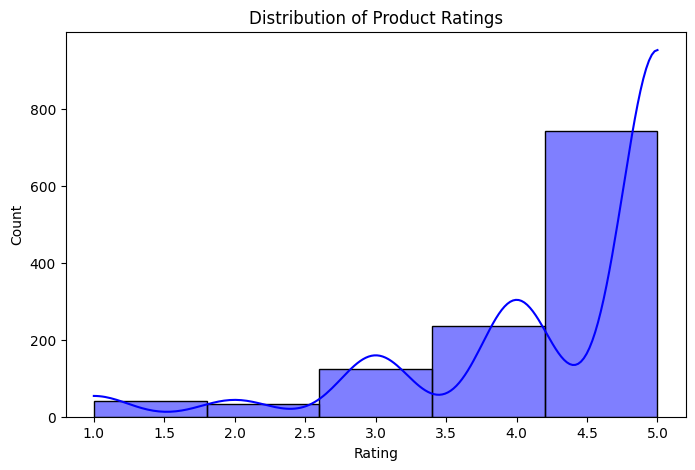

In [22]:
# RATINGS DISTRIBUTION

plt.figure(figsize=(8,5))
sns.histplot(df_filtered['rating'], bins=5, kde=True, color='blue')
plt.title('Distribution of Product Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

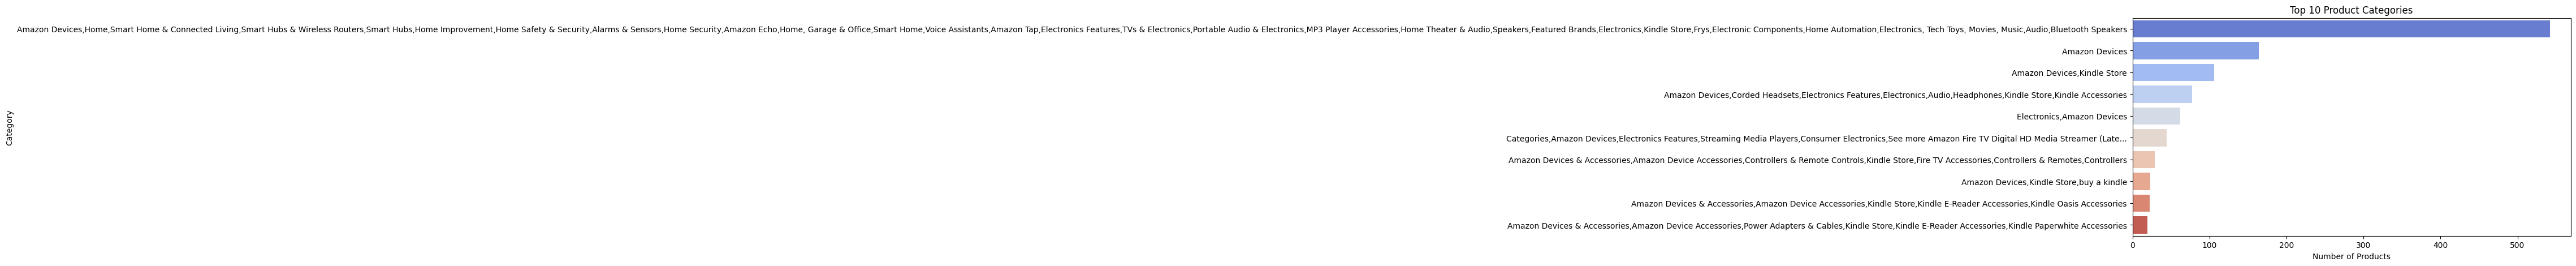

In [23]:
# TOP PRODUCT CATEGORIES

top_categories = df_filtered['category'].value_counts().nlargest(10)

plt.figure(figsize=(10,5))
sns.barplot(y=top_categories.index,x=top_categories.values,hue=top_categories.index,palette='coolwarm',legend=False)
plt.title('Top 10 Product Categories')
plt.xlabel('Number of Products')
plt.ylabel('Category')
plt.show()


In [24]:
# CONTENT-BASED FILTERING

# Remove duplicate product entries to ensure unique recommendations
df_unique_products = df_filtered.drop_duplicates(subset=['product_id']).reset_index(drop=True)

# Apply TF-IDF vectorization on product categories
vectorizer = TfidfVectorizer(stop_words='english')
category_matrix = vectorizer.fit_transform(df_unique_products['category'].fillna(''))

# Compute cosine similarity between products based on category
cosine_sim = cosine_similarity(category_matrix, category_matrix)

# Store product indices for lookup
product_id_to_index = {pid: index for index, pid in enumerate(df_unique_products['product_id'])}

def recommend_products_by_id(product_id, num_recommendations=5):
    """Recommends products based on category similarity."""
    if product_id not in product_id_to_index:
        return "Product ID not found."

    idx = product_id_to_index[product_id]
    similarity_scores = cosine_sim[idx]
    similar_indices = np.argsort(similarity_scores)[::-1][1:num_recommendations+1]

    return df_unique_products.iloc[similar_indices][['product_id', 'product_name', 'category']]

In [25]:
# EXAMPLE CONTENT-BASED RECOMMENDATION

# Example: Recommend products similar to 'Kindle Paperwhite'
example_product_id = df_filtered[df_filtered['product_name'] == 'Kindle Paperwhite']['product_id'].values[0]
recommend_products_by_id(example_product_id)

,product_id,product_name,category
17,AVpg4dIu1cnluZ0-7fWM,Kindle Paperwhite 3G,Amazon Devices
30,AV1T19kvglJLPUi8H8Y-,Kindle Oasis E-reader with Leather Charging Co...,Amazon Devices
29,AV1T1u7jvKc47QAVgf3J,Fire HDX 8.9 Tablet,Amazon Devices
28,AV1T19mDGV-KLJ3adSMT,Kindle Oasis with Leather Charging Cover - Black,Amazon Devices
27,AV1T19jOglJLPUi8H8Y9,Certified Refurbished Kindle Paperwhite E-read...,Amazon Devices


In [26]:
# COLLABORATIVE FILTERING

# Define the reader with rating scale
reader = Reader(rating_scale=(1, 5))

# Load dataset into Surprise format
data = Dataset.load_from_df(df_filtered[['user', 'product_id', 'rating']], reader)

# Split into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Initialize and train the SVD model
model = SVD()
model.fit(trainset)

# Evaluate the model using cross-validation
cv_results = cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
cv_results

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8770  0.9119  0.8684  0.8257  0.9471  0.8860  0.0410  
MAE (testset)     0.5992  0.6550  0.6375  0.6174  0.6696  0.6357  0.0253  
Fit time          0.02    0.00    0.01    0.01    0.01    0.01    0.01    
Test time         0.02    0.00    0.00    0.00    0.00    0.00    0.01    


{'test_rmse': array([0.87700568, 0.91190027, 0.86838175, 0.82572788, 0.94705324]),
 'test_mae': array([0.59917639, 0.65504185, 0.63753879, 0.61741054, 0.66956674]),
 'fit_time': (0.015603780746459961,
  0.0,
  0.012371540069580078,
  0.011174440383911133,
  0.008969545364379883),
 'test_time': (0.015648603439331055,
  0.0,
  0.0009968280792236328,
  0.0009949207305908203,
  0.000995635986328125)}

In [27]:
# HYBRID RECOMMENDATION

def hybrid_recommendation(user, product_id, num_recommendations=5):
    """Combines collaborative and content-based filtering."""
    if product_id not in product_id_to_index:
        return "Product ID not found."

    # Content-based recommendations
    content_recs = recommend_products_by_id(product_id, num_recommendations)

    # Collaborative filtering predictions
    predicted_ratings = [model.predict(user, pid).est for pid in content_recs['product_id']]
    content_recs['predicted_rating'] = predicted_ratings

    return content_recs.sort_values(by='predicted_rating', ascending=False)

# Example Hybrid Recommendation
hybrid_recommendation('user123', example_product_id)

,product_id,product_name,category,predicted_rating
27,AV1T19jOglJLPUi8H8Y9,Certified Refurbished Kindle Paperwhite E-read...,Amazon Devices,4.496333
17,AVpg4dIu1cnluZ0-7fWM,Kindle Paperwhite 3G,Amazon Devices,4.455576
30,AV1T19kvglJLPUi8H8Y-,Kindle Oasis E-reader with Leather Charging Co...,Amazon Devices,4.359979
29,AV1T1u7jvKc47QAVgf3J,Fire HDX 8.9 Tablet,Amazon Devices,4.359513
28,AV1T19mDGV-KLJ3adSMT,Kindle Oasis with Leather Charging Cover - Black,Amazon Devices,4.302791
